In [1]:
import numpy as np
import matplotlib.pyplot as plt
from icecream import ic
from copy import deepcopy

def soft_thresh(x, l):
    return np.sign(x) * np.maximum(np.abs(x) - l, 0)

def fftc(x):
    return 1 / np.sqrt(np.prod(x.shape)) * np.fft.ifftshift(np.fft.fft(np.fft.ifftshift(x)))

def ifftc(y):
    return np.sqrt(np.prod(y.shape)) * np.fft.ifftshift(np.fft.ifft(np.fft.fftshift(y)))

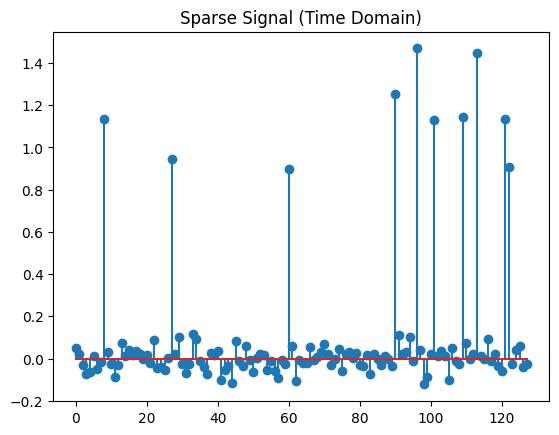

In [2]:
np.random.seed(0)

# Hyperparameters.
n = 128  # Dimensionality of the sparse signal
k = 10  # Number of non-zero elements in the sparse signal
sample_n = 32  # Number of samples to take in the non sparse domain
t = np.zeros(n)
nzc = np.random.rand(k) + 0.5
t[np.random.choice(n, k, replace=False)] = nzc

# Add gaussian noise to the original signal.
sigma = 0.05
t += np.random.randn(n) * sigma

# Visualise the original signal.
plt.stem(t)
plt.title('Sparse Signal (Time Domain)')
plt.show()

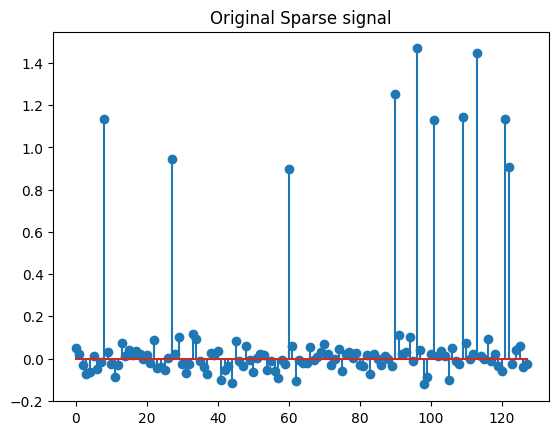

/Users/vishaljain/anaconda3/envs/ia_vj279/lib/python3.11/site-packages/matplotlib/cbook.py:1762: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/Users/vishaljain/anaconda3/envs/ia_vj279/lib/python3.11/site-packages/numpy/ma/core.py:3387: ComplexWarning: Casting complex values to real discards the imaginary part
  _data[indx] = dval
/Users/vishaljain/anaconda3/envs/ia_vj279/lib/python3.11/site-packages/matplotlib/cbook.py:1398: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


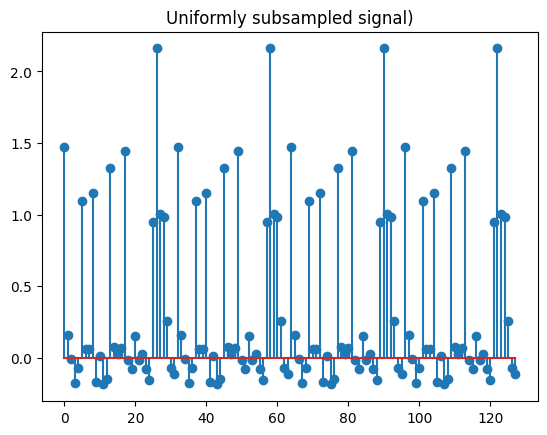

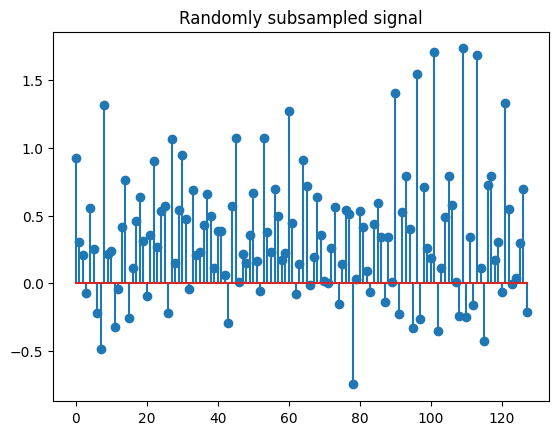

In [3]:
# Move to non sparse freq domain via FFT.
f = fftc(t)

# Subsample the signal uniformly and randomly.
uniform_mask = np.zeros(n)
uniform_mask_idxs = np.arange(n, step=n // sample_n)[:sample_n]
uniform_mask[uniform_mask_idxs] = 1

random_mask = np.zeros(n)
random_idx = sorted(np.random.choice(n, sample_n, replace=False))
random_mask[random_idx] = 1

uniform_sampled_f = f * uniform_mask
random_sampled_f = f * random_mask

# Reconstruct the signal (time domain) from the subsampled specta (freq domain).
uniform_sampled_t = ifftc(uniform_sampled_f) * (n // sample_n)
random_sampled_t = ifftc(random_sampled_f) * (n // sample_n)

# Visualise the reconstructed spectra.
plt.stem(t)
plt.title('Original Sparse signal')
plt.show()

plt.stem(uniform_sampled_t)
plt.title('Uniformly subsampled signal)')
plt.show()

plt.stem(random_sampled_t)
plt.title('Randomly subsampled signal')
plt.show()

In [4]:
# Apply iterative soft thresholding to recover the sparse signal.
def POCS(f_obs, lam, nitr, ref):
    err = np.zeros((nitr,))
    # Copy the observed signal.
    f_i = f_obs.copy()
    for i in range(nitr):
        # Go to time (sparse) domain.
        t_i = ifftc(f_i)
        
        # Apply soft thresholding.
        t_i = soft_thresh(t_i, lam)
        
        # Go back to freq domain.
        f_i = fftc(t_i)
        
        # Enforce the observed values.
        f_i = f_i*(f_obs == 0) + f_obs
        
        # Compute the error.
        err[i] = np.linalg.norm(f_i - ref)
    
    # Return the sparse time signal and the error.
    final_t = ifftc(f_i)
    return final_t, err

recovered_t_uniform, err_uniform = POCS(uniform_sampled_f, 0.01, 100, f)
recovered_t_random, err_random = POCS(random_sampled_f, 0.01, 100, f)

print('Uniform sampling error:', err_uniform[-1])
print('Random sampling error:', err_random[-1])


Uniform sampling error: 3.115948688372301
Random sampling error: 0.7930788635318219


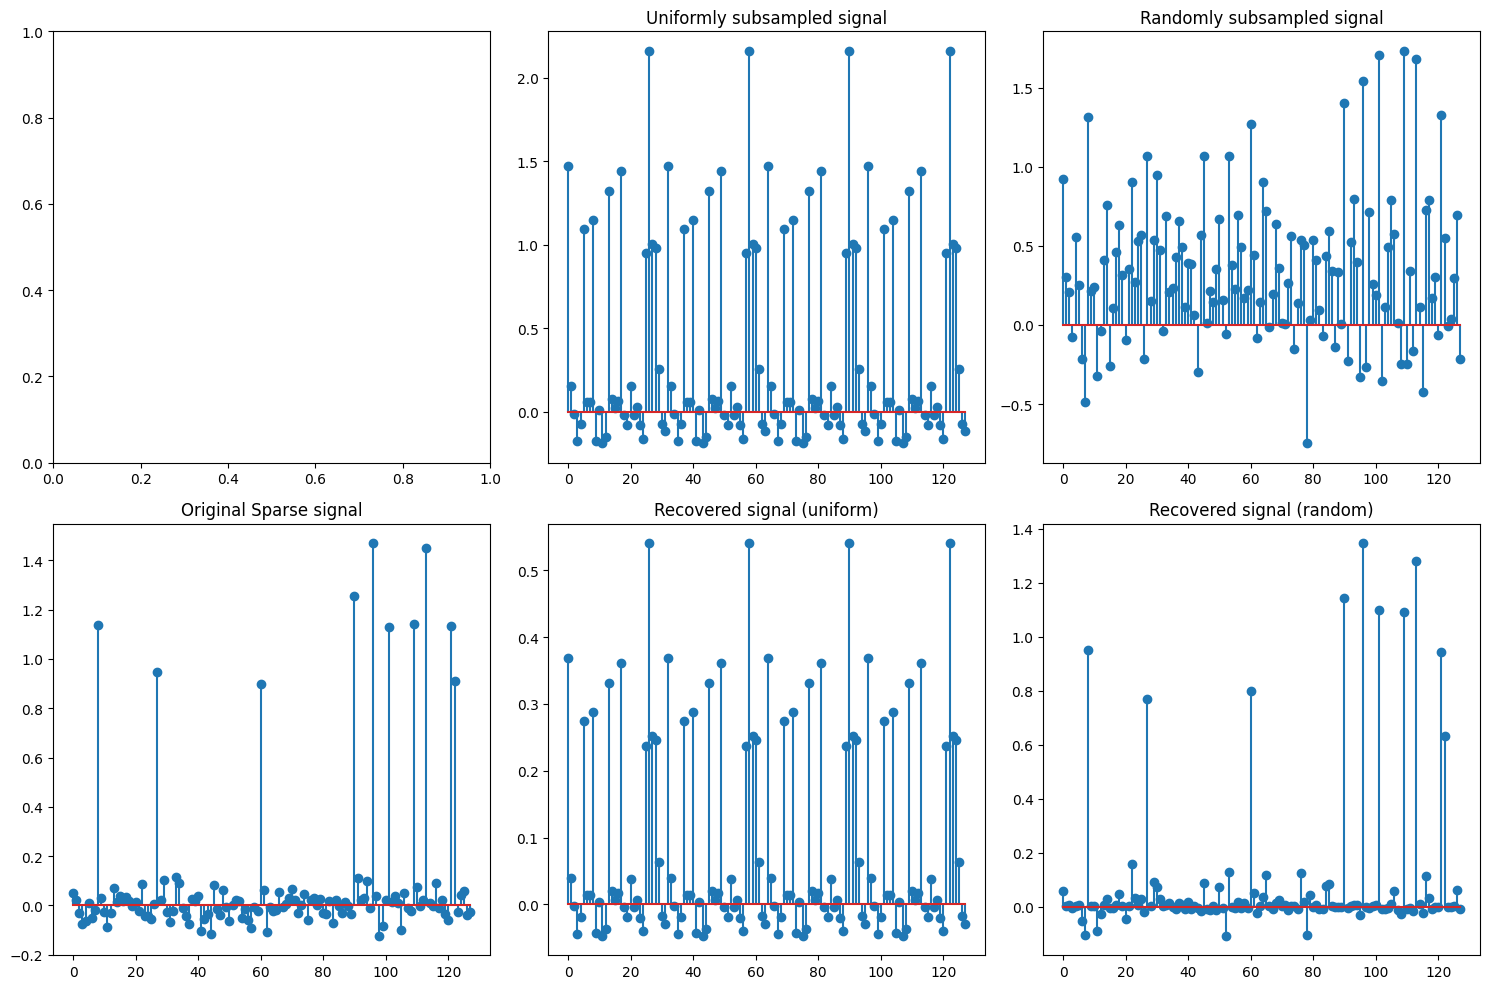

In [5]:
# Visualise the recovered signals.
fig, ax = plt.subplots(nrows = 2, ncols=3, figsize=(15, 10))

ax[0, 1].stem(uniform_sampled_t)
ax[0, 1].set_title('Uniformly subsampled signal')

ax[0, 2].stem(random_sampled_t)
ax[0, 2].set_title('Randomly subsampled signal')

ax[1, 0].stem(t)
ax[1, 0].set_title('Original Sparse signal')

ax[1, 1].stem(recovered_t_uniform)
ax[1, 1].set_title('Recovered signal (uniform)')

ax[1, 2].stem(recovered_t_random)
ax[1, 2].set_title('Recovered signal (random)')
plt.tight_layout()
plt.show()




